In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold,RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder,RobustScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc,f1_score
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight,compute_sample_weight
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC, LinearSVC
from scipy.stats import loguniform
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("train.csv")
df.head()
df.info()
df.isna().sum()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   participant_id             1913 non-null   int64  
 1   age_group                  1913 non-null   int64  
 2   identity_code              1913 non-null   int64  
 3   cultural_background        1913 non-null   int64  
 4   upbringing_influence       1913 non-null   int64  
 5   focus_intensity            1913 non-null   float64
 6   consistency_score          1913 non-null   int64  
 7   external_guidance_usage    1913 non-null   int64  
 8   support_environment_score  1913 non-null   int64  
 9   hobby_engagement_level     1913 non-null   int64  
 10  physical_activity_index    1913 non-null   int64  
 11  creative_expression_index  1913 non-null   int64  
 12  altruism_score             1913 non-null   int64  
 13  personality_cluster        1913 non-null   objec

,participant_id,age_group,identity_code,cultural_background,upbringing_influence,focus_intensity,consistency_score,external_guidance_usage,support_environment_score,hobby_engagement_level,physical_activity_index,creative_expression_index,altruism_score
count,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000,1913.000000
mean,1195.642446,16.456351,0.514375,0.872974,1.764245,9.748506,14.618400,0.302143,2.140617,0.380031,0.304757,0.198118,0.156299
std,687.474019,1.124705,0.499924,1.031951,0.988605,5.702764,8.485326,0.459307,1.118309,0.485521,0.460425,0.398686,0.363234
min,1.000000,15.000000,0.000000,0.000000,0.000000,0.008031,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,613.000000,15.000000,0.000000,0.000000,1.000000,4.958649,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1189.000000,16.000000,1.000000,0.000000,2.000000,9.518844,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,1787.000000,17.000000,1.000000,2.000000,2.000000,14.407464,22.000000,1.000000,3.000000,1.000000,1.000000,0.000000,0.000000
max,2392.000000,18.000000,1.000000,3.000000,4.000000,19.968425,29.000000,1.000000,4.000000,1.000000,1.000000,1.000000,1.000000


In [3]:
df['personality_cluster'].value_counts(normalize=True)

personality_cluster
Cluster_E    0.509148
Cluster_D    0.171458
Cluster_C    0.159958
Cluster_B    0.115003
Cluster_A    0.044433
Name: proportion, dtype: float64

In [4]:
#preprocessing
df["lifestyle_balance"] = (
    df["physical_activity_index"] +
    df["creative_expression_index"] +
    df["hobby_engagement_level"]
) / 3

In [5]:
df["stability_score"] = (
    df["support_environment_score"] +
    df["consistency_score"]
) / 2


In [6]:
df["expressive_altruism_ratio"] = df["creative_expression_index"] / (df["altruism_score"] + 1)
df["internal_external_balance"] = df["focus_intensity"] / (df["external_guidance_usage"] + 1)
df["personality_strength"] = (
    df["focus_intensity"] + 
    df["consistency_score"] +
    df["altruism_score"]
)


In [7]:
df["focus_consistency"] = df["focus_intensity"] * df["consistency_score"]
df["activity_creativity"] = df["physical_activity_index"] * df["creative_expression_index"]
df["upbringing_identity"] = df["upbringing_influence"] * df["identity_code"]
df["log_focus"] = np.log1p(df["focus_intensity"])
poly = PolynomialFeatures(degree=2, include_bias=False)

In [8]:
df["mental_balance_ratio"] = (
    df["focus_intensity"] / (df["consistency_score"] + 1)
)

df["social_support_ratio"] = (
    df["support_environment_score"] / (df["external_guidance_usage"] + 1)
)

df["creativity_activity_ratio"] = (
    df["creative_expression_index"] / (df["physical_activity_index"] + 1)
)

df["altruistic_expression_ratio"] = (
    df["altruism_score"] / (df["creative_expression_index"] + 1)
)


In [9]:
df["identity_focus_interaction"] = (
    df["identity_code"] * df["focus_intensity"]
)

df["identity_upbringing_interaction"] = (
    df["identity_code"] * df["upbringing_influence"]
)

df["personality_uniqueness"] = (
    df["identity_code"] * df["creative_expression_index"]
)

df["engagement_multiplier"] = (
    df["hobby_engagement_level"] *
    df["physical_activity_index"] *
    df["creative_expression_index"]
) ** (1/3)

In [10]:
df["activity_minus_creativity"] = (
    df["physical_activity_index"] - df["creative_expression_index"]
)

df["focus_minus_consistency"] = (
    df["focus_intensity"] - df["consistency_score"]
)

df["support_minus_guidance"] = (
    df["support_environment_score"] - df["external_guidance_usage"]
)


In [11]:
df["expression_energy"] = (
    df["creative_expression_index"] +
    df["focus_intensity"] +
    df["physical_activity_index"]
)

df["consistency_behavior_index"] = (
    df["consistency_score"] +
    df["stability_score"]
)

df["overall_social_factor"] = (
    df["support_environment_score"] +
    df["external_guidance_usage"] +
    df["altruism_score"]
)

In [12]:
poly_cols = [
    "focus_intensity",
    "creative_expression_index",
    "hobby_engagement_level",
    "physical_activity_index",
    "altruism_score",
]

for col in poly_cols:
    df[f"{col}_squared"] = df[col] ** 2

In [13]:
X = df.drop("personality_cluster", axis=1)
y = df["personality_cluster"]
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y),
    y=y
)
class_weights_dict = dict(zip(np.unique(y), weights))

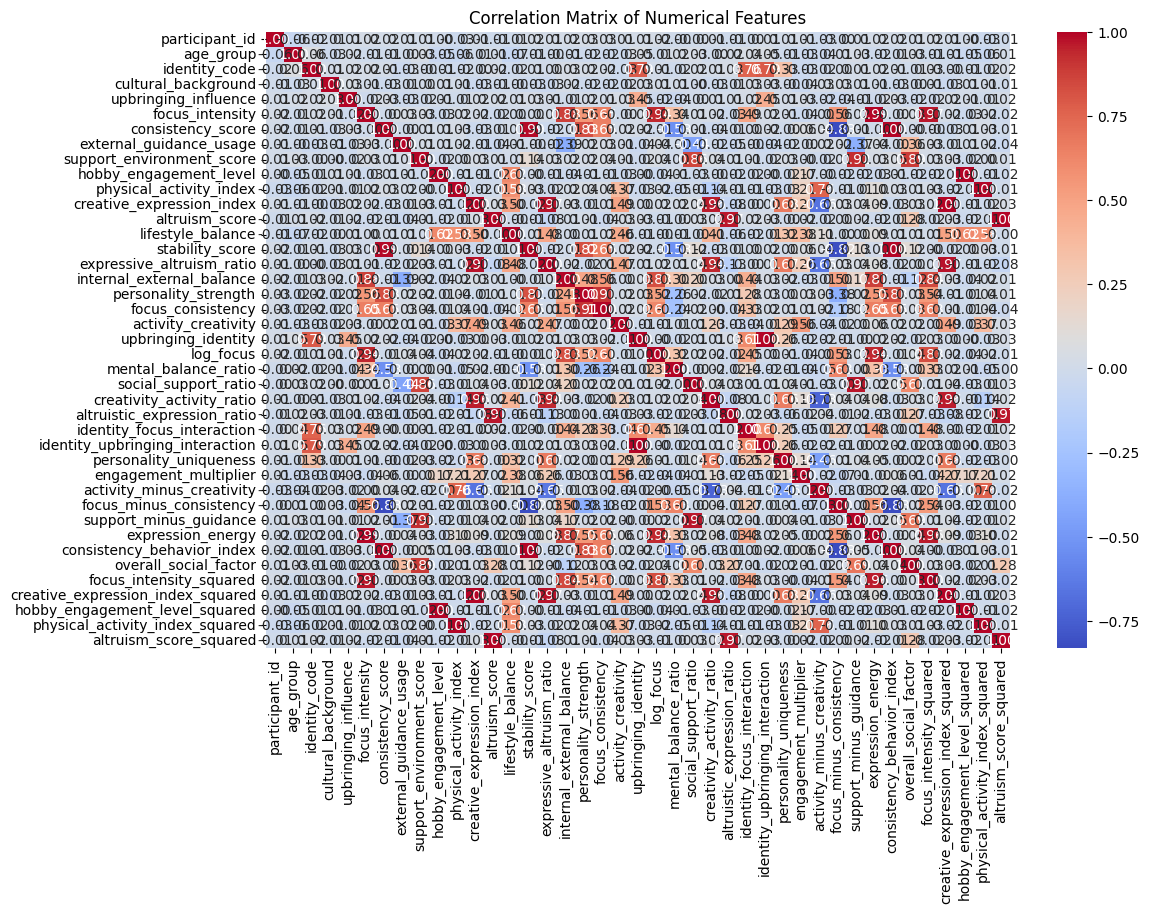

In [14]:
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [15]:
skew_values = df.skew(numeric_only=True)

print("\nSkewness of numerical columns:")
print(skew_values)
skewed_cols = skew_values[abs(skew_values) > 0.75].index.tolist()

print("\nHighly skewed columns (|skew| > 0.75):")
print(skewed_cols)


Skewness of numerical columns:
participant_id                       0.001347
age_group                            0.053725
identity_code                       -0.057570
cultural_background                  0.770295
upbringing_influence                 0.189502
focus_intensity                      0.057411
consistency_score                   -0.032740
external_guidance_usage              0.862446
support_environment_score           -0.173339
hobby_engagement_level               0.494702
physical_activity_index              0.848987
creative_expression_index            1.515969
altruism_score                       1.894432
lifestyle_balance                    0.445239
stability_score                     -0.033122
expressive_altruism_ratio            1.659406
internal_external_balance            0.448874
personality_strength                 0.022802
focus_consistency                    1.008811
activity_creativity                  3.825418
upbringing_identity                  0.889251
lo

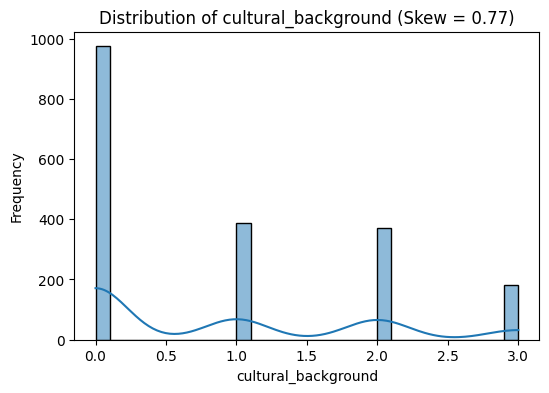

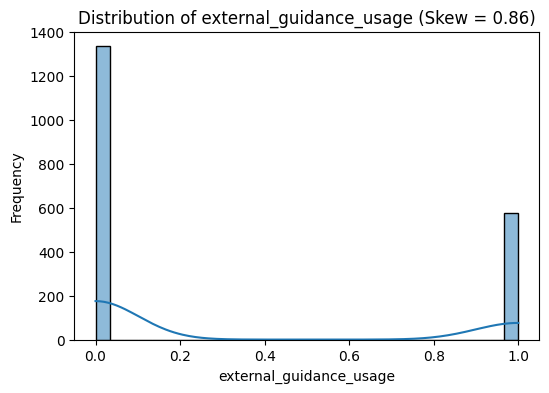

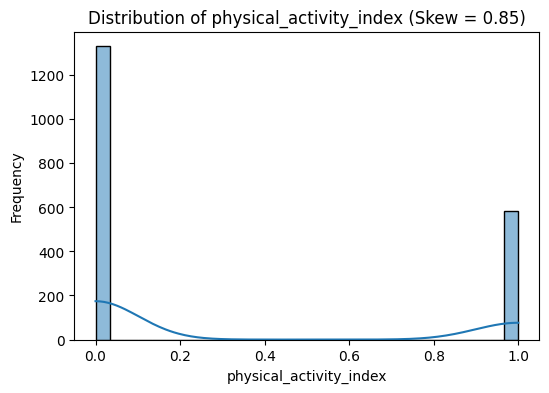

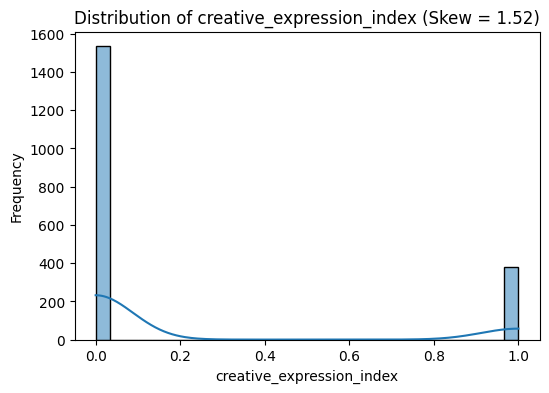

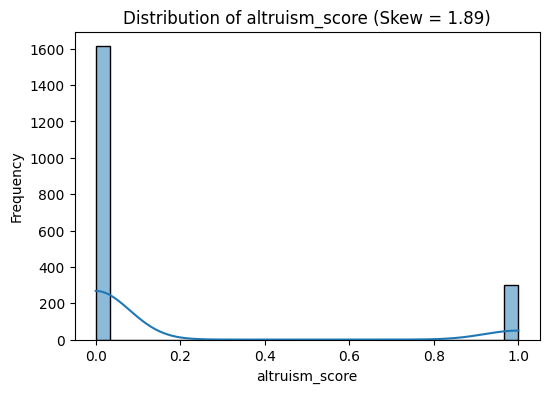

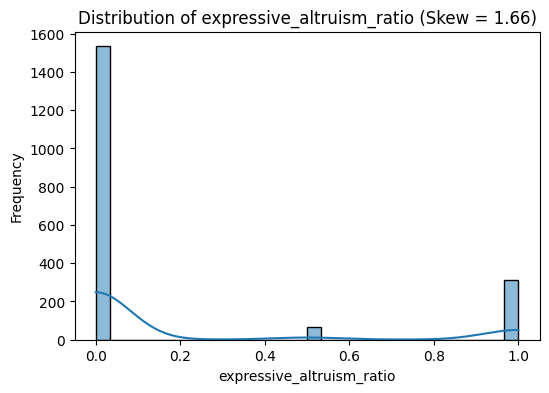

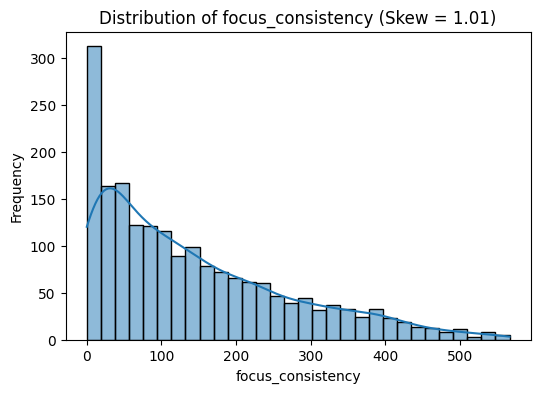

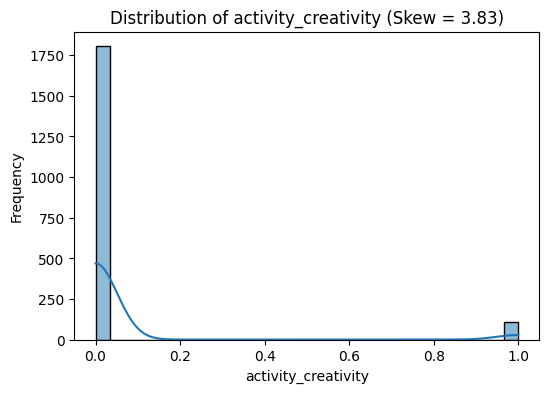

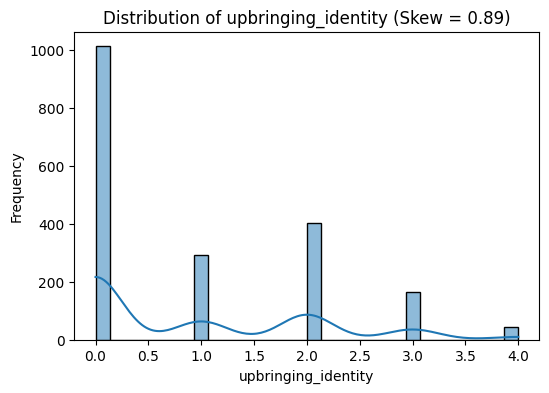

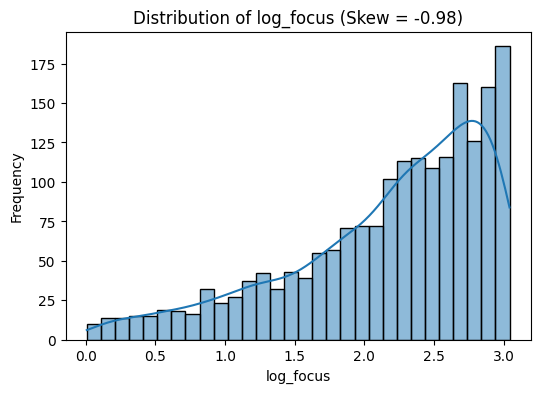

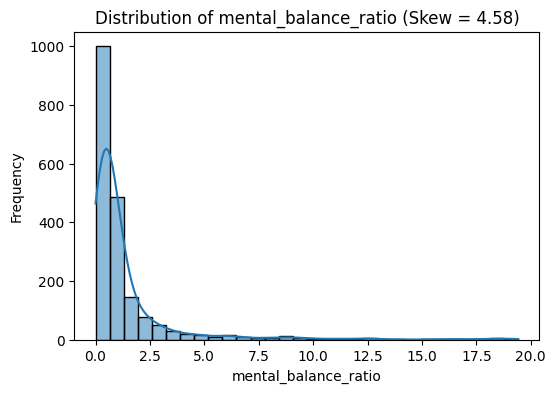

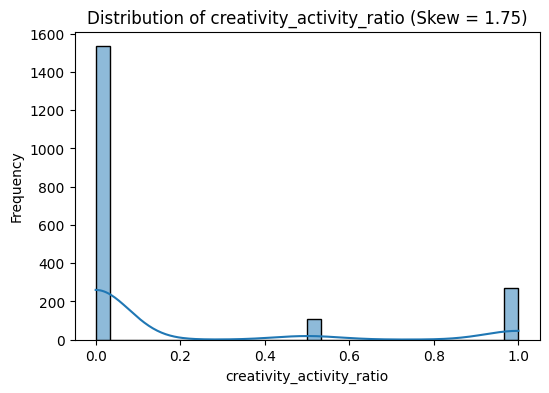

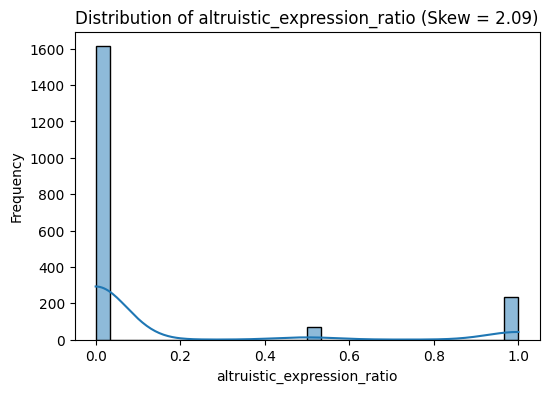

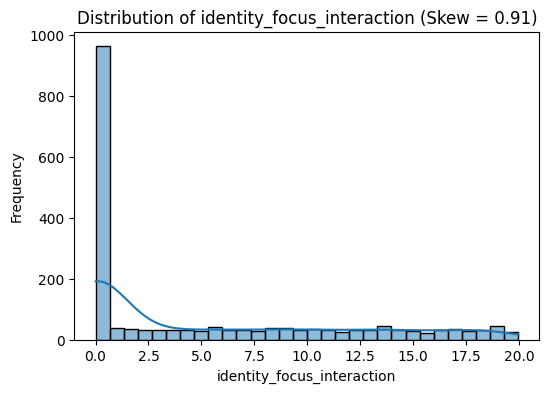

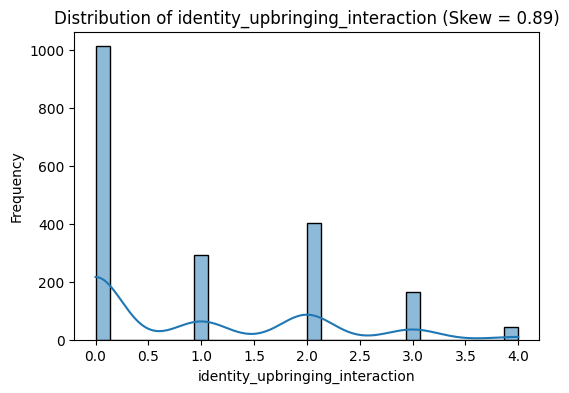

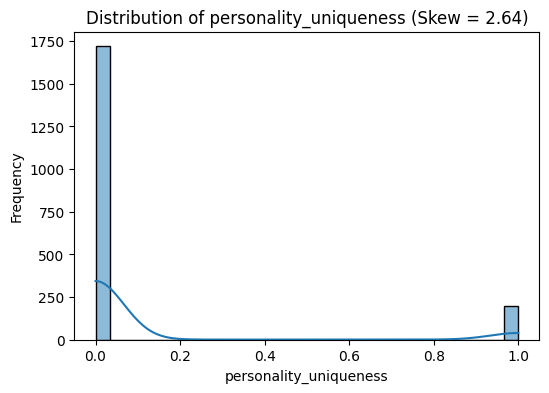

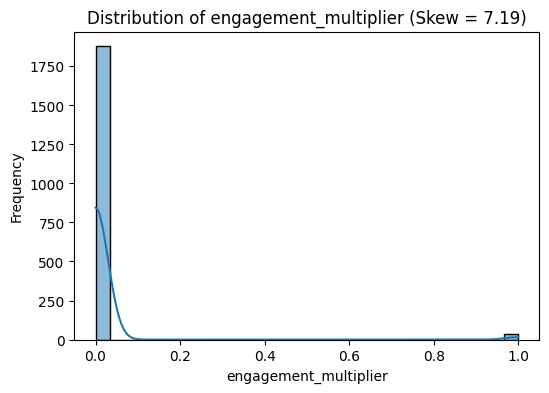

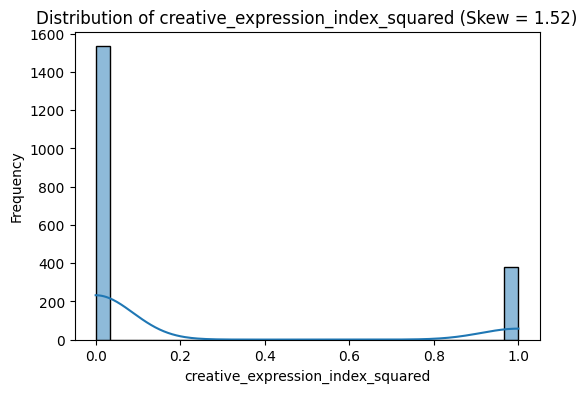

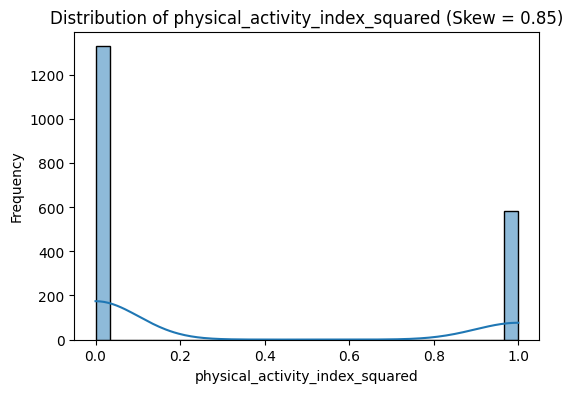

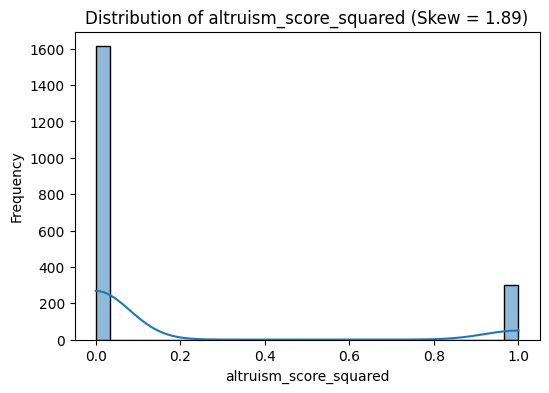

In [16]:
for col in skewed_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col} (Skew = {skew_values[col]:.2f})")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [17]:
le = LabelEncoder()
y_enc = le.fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print('\nTraining shape:', X_train.shape, 'Validation shape:', X_val.shape)
feature_cols = X.columns.tolist()


Training shape: (1530, 41) Validation shape: (383, 41)


In [18]:
scaler = RobustScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)


In [19]:
classes = np.unique(y_enc)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_enc)
class_weight_dict = {i: w for i, w in zip(classes, class_weights)}

print("Class Weights:", class_weight_dict)
df.info()


Class Weights: {0: 4.501176470588235, 1: 1.739090909090909, 2: 1.250326797385621, 3: 1.1664634146341464, 4: 0.39281314168377823}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 42 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   participant_id                     1913 non-null   int64  
 1   age_group                          1913 non-null   int64  
 2   identity_code                      1913 non-null   int64  
 3   cultural_background                1913 non-null   int64  
 4   upbringing_influence               1913 non-null   int64  
 5   focus_intensity                    1913 non-null   float64
 6   consistency_score                  1913 non-null   int64  
 7   external_guidance_usage            1913 non-null   int64  
 8   support_environment_score          1913 non-null   int64  
 9   hobby_engagement_level             1913 non-null   int6

In [20]:
pca_candidate_cols = [
    c for c in X_train.columns
    if X_train[c].dtype != "object" and 
       ("pca" not in c) and 
       ("cluster" not in c)
]

print("PCA candidates:", len(pca_candidate_cols))

# Find indices of PCA candidates
pca_idxs = [X_train.columns.get_loc(c) for c in pca_candidate_cols]

PCA candidates: 41


In [21]:

pca = PCA(n_components=0.95, random_state=42)
X_train_p = pca.fit_transform(X_train_s[:, pca_idxs])
X_val_p   = pca.transform(X_val_s[:, pca_idxs])

print("PCA components:", pca.n_components_)
X_train_final = np.hstack([X_train_s, X_train_p])
X_val_final   = np.hstack([X_val_s, X_val_p])

print("Final train shape:", X_train_final.shape)
print("Final val shape:", X_val_final.shape)

# pca_candidates = ["expressive_altruism_ratio", "focus_consistency", "activity_creativity"]
# pca_cols = [c for c in pca_candidates if c in X.columns]
# print("Using PCA columns:", pca_cols)


# if len(pca_cols) >= 2:
#     pca = PCA(n_components=min(3, len(pca_cols)), random_state=42)
    
#     idxs = [X.columns.get_loc(c) for c in pca_cols]

#     X_train_p = pca.fit_transform(X_train_s[:, idxs])
#     X_val_p   = pca.transform(X_val_s[:, idxs])

#     X_train_final = np.hstack([X_train_s, X_train_p])
#     X_val_final   = np.hstack([X_val_s, X_val_p])

#     print("Final feature count:", X_train_final.shape[1])

# else:
#     print("Skipping PCA")
#     X_train_final = X_train_s
#     X_val_final   = X_val_s


PCA components: 12
Final train shape: (1530, 53)
Final val shape: (383, 53)


In [22]:
svm_linear = LinearSVC(class_weight=class_weight_dict)
svm_linear.fit(X_train, y_train)
pred_linear = svm_linear.predict(X_val)
print("\nLinear SVM Macro F1:", f1_score(y_val, pred_linear, average="macro"))


Linear SVM Macro F1: 0.5246315611339089


In [23]:
svm_rbf = SVC(
    kernel="rbf",
    C=3,
    gamma="scale",
    class_weight=class_weight_dict
)

svm_rbf.fit(X_train, y_train)
pred_rbf = svm_rbf.predict(X_val)

print("\nRBF SVM Macro F1:", f1_score(y_val, pred_rbf, average="macro"))
print("\nRBF Classification Report:")
print(classification_report(y_val, pred_rbf))



RBF SVM Macro F1: 0.4289044384716222

RBF Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.59      0.28        17
           1       0.45      0.20      0.28        44
           2       0.31      0.59      0.40        61
           3       0.43      0.35      0.39        66
           4       0.96      0.68      0.79       195

    accuracy                           0.55       383
   macro avg       0.47      0.48      0.43       383
weighted avg       0.67      0.55      0.58       383



In [24]:
svm_model = SVC(kernel="rbf", probability=True, class_weight="balanced",random_state=42)

param_grid = {
    "C": [1, 3, 10],
    "gamma": ["scale", 0.1, 0.01]
    # "C": loguniform(1e-2, 1e3),
    # "gamma": loguniform(1e-4, 1e0)
}

svm_grid = GridSearchCV(
    svm_model,
    param_grid,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1
)
# svm_search = RandomizedSearchCV(
#     svm_model,
#     param_grid,
#     n_iter=50,        # deep search
#     scoring="f1_macro",
#     cv=3,
#     verbose=2,
#     n_jobs=-1,
#     random_state=42
# )

svm_grid.fit(X_train_final, y_train)
best_svm = svm_grid.best_estimator_

print("Best SVM params:", svm_grid.best_params_)


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best SVM params: {'C': 1, 'gamma': 0.01}


In [25]:
svm_pred = best_svm.predict(X_val_final)
svm_proba = best_svm.predict_proba(X_val_final)

print("SVM Macro F1:", f1_score(y_val, svm_pred, average="macro"))
print(classification_report(y_val, svm_pred))


SVM Macro F1: 0.5760332246131179
              precision    recall  f1-score   support

           0       0.35      0.47      0.40        17
           1       0.51      0.45      0.48        44
           2       0.54      0.44      0.49        61
           3       0.52      0.79      0.63        66
           4       0.95      0.83      0.89       195

    accuracy                           0.70       383
   macro avg       0.57      0.60      0.58       383
weighted avg       0.73      0.70      0.71       383



In [26]:
sm_c = SMOTE(k_neighbors=2,random_state=42)
X_train_res, y_train_res = sm_c.fit_resample(X_train, y_train)

# Define neural network
mlp_c = MLPClassifier(
    hidden_layer_sizes=(128, 64, 32),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=500,
    early_stopping=True,
    random_state=42
)

# Train on oversampled data
mlp_c.fit(X_train_res, y_train_res)

# Predict on original validation set
pred_mlp = mlp_c.predict(X_val)

print("MLP Macro F1:", f1_score(y_val, pred_mlp, average="macro"))
print("\nClassification Report:")
print(classification_report(y_val, pred_mlp))

MLP Macro F1: 0.47043757025790695

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.35      0.29        17
           1       0.37      0.59      0.45        44
           2       0.49      0.28      0.35        61
           3       0.36      0.61      0.45        66
           4       0.95      0.69      0.80       195

    accuracy                           0.58       383
   macro avg       0.48      0.50      0.47       383
weighted avg       0.68      0.58      0.61       383



In [27]:
sm = SMOTE(k_neighbors=2, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_final, y_train)
mlp = MLPClassifier(
    max_iter=500,
    early_stopping=True,
    random_state=42
)

param_dist = {
    "hidden_layer_sizes": [(64,32), (128,64,32), (256,128)],
    "activation": ["relu", "tanh"],
    "alpha": [1e-4, 1e-3, 1e-2],
    "learning_rate_init": [1e-3, 5e-4, 1e-4],
    # "hidden_layer_sizes": [
    #     (128,), (256,),
    #     (128,64), (256,128),
    #     (256,128,64), (512,256,128)
    # ],
    # "learning_rate_init": [1e-4, 3e-4, 1e-3, 3e-3],
    # "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    # "activation": ["relu", "tanh"],
    # "solver": ["adam", "lbfgs"]
}

mlp_search = RandomizedSearchCV(
    mlp,
    param_dist,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    random_state=42,
    verbose=2
)

mlp_search.fit(X_train_res, y_train_res)
best_mlp = mlp_search.best_estimator_

print("Best MLP params:", mlp_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best MLP params: {'learning_rate_init': 0.001, 'hidden_layer_sizes': (256, 128), 'alpha': 0.01, 'activation': 'relu'}


In [28]:
mlp_pred = best_mlp.predict(X_val_final)
mlp_proba = best_mlp.predict_proba(X_val_final)


print("MLP Macro F1:", f1_score(y_val, mlp_pred, average="macro"))
print(classification_report(y_val, mlp_pred))


MLP Macro F1: 0.6158429663398788
              precision    recall  f1-score   support

           0       0.50      0.35      0.41        17
           1       0.61      0.57      0.59        44
           2       0.58      0.59      0.59        61
           3       0.54      0.68      0.60        66
           4       0.92      0.87      0.89       195

    accuracy                           0.73       383
   macro avg       0.63      0.61      0.62       383
weighted avg       0.74      0.73      0.74       383



In [29]:
xgb = XGBClassifier(
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
    # objective="multi:softprob",
    # num_class=5,
    # eval_metric="mlogloss",
    # random_state=42,
    # tree_method="hist"
)

param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "n_estimators": [200, 400, 600],
    "subsample": [0.7, 0.9, 1],
    "colsample_bytree": [0.7, 0.9, 1]
    # "n_estimators": [300, 500, 700, 900],
    # "learning_rate": [0.001, 0.005, 0.01, 0.05, 0.1],
    # "max_depth": [3, 5, 7, 9, 12],
    # "min_child_weight": [1, 3, 5, 7],
    # "subsample": [0.6, 0.75, 0.9, 1.0],
    # "colsample_bytree": [0.6, 0.75, 0.9, 1.0],
    # "gamma": [0, 0.5, 1, 2, 5],
    # "reg_alpha": [0, 0.1, 0.5, 1, 2],
    # "reg_lambda": [1, 2, 3, 4, 5],
}

In [30]:
xgb_search = RandomizedSearchCV(
    xgb,
    param_grid,
    n_iter=20,
    scoring="f1_macro",
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
    # xgb,
    # param_grid,
    # n_iter=50,         # DEEP search
    # scoring="f1_macro",
    # cv=3,
    # verbose=2,
    # n_jobs=-1,
    # random_state=42
)

xgb_search.fit(X_train_final, y_train)
best_xgb = xgb_search.best_estimator_

pred_xgb = best_xgb.predict(X_val_final)
proba_xgb = best_xgb.predict_proba(X_val_final)

print("XGBoost Macro F1:", f1_score(y_val, pred_xgb, average="macro"))
print(classification_report(y_val, pred_xgb))

Fitting 3 folds for each of 20 candidates, totalling 60 fits


c:\Users\thriv\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:56:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Macro F1: 0.5909638902922435
              precision    recall  f1-score   support

           0       0.60      0.35      0.44        17
           1       0.55      0.52      0.53        44
           2       0.52      0.52      0.52        61
           3       0.54      0.55      0.54        66
           4       0.89      0.93      0.91       195

    accuracy                           0.73       383
   macro avg       0.62      0.57      0.59       383
weighted avg       0.72      0.73      0.72       383



In [31]:
rf = RandomForestClassifier(
    class_weight="balanced",
    random_state=42
)
# rf_params = {
#     "n_estimators": [300, 500, 800],
#     "max_depth": [None, 10, 20, 30],
#     "min_samples_split": [2, 5, 10],
#     "min_samples_leaf": [1, 2, 4],
#     "max_features": ["sqrt", "log2", None]
# }
# rf_grid = GridSearchCV(
#     rf,
#     rf_params,
#     scoring="f1_macro",
#     cv=3,
#     verbose=2,
#     n_jobs=-1
# )
rf.fit(X_train_final, y_train)
pred_rf = rf.predict(X_val_final)
proba_rf = rf.predict_proba(X_val_final)

print("RF Macro F1:", f1_score(y_val, pred_rf, average="macro"))

RF Macro F1: 0.6180042336013132


In [32]:
ensemble_proba = (svm_proba + mlp_proba) / 2
ensemble_pred = np.argmax(ensemble_proba, axis=1)

print("Ensemble Macro F1:", f1_score(y_val, ensemble_pred, average="macro"))
print(classification_report(y_val, ensemble_pred))


Ensemble Macro F1: 0.6400984271567642
              precision    recall  f1-score   support

           0       0.60      0.35      0.44        17
           1       0.62      0.57      0.60        44
           2       0.62      0.61      0.61        61
           3       0.60      0.68      0.64        66
           4       0.90      0.92      0.91       195

    accuracy                           0.76       383
   macro avg       0.67      0.63      0.64       383
weighted avg       0.76      0.76      0.76       383



In [33]:
final_proba = (
    svm_proba +
    mlp_proba +
    proba_xgb +
    proba_rf
) / 4

final_pred = np.argmax(final_proba, axis=1)

print("SUPER ENSEMBLE MACRO F1:", f1_score(y_val, final_pred, average="macro"))
print(classification_report(y_val, final_pred))


SUPER ENSEMBLE MACRO F1: 0.6181675213675214
              precision    recall  f1-score   support

           0       0.56      0.29      0.38        17
           1       0.61      0.50      0.55        44
           2       0.61      0.64      0.62        61
           3       0.61      0.64      0.62        66
           4       0.89      0.93      0.91       195

    accuracy                           0.76       383
   macro avg       0.65      0.60      0.62       383
weighted avg       0.75      0.76      0.75       383



In [34]:
test_df = pd.read_csv("test.csv")
print("Test shape:", test_df.shape)

# Detect ID column (your train uses participant_id)
id_col = "participant_id" if "participant_id" in test_df.columns else None

if id_col:
    test_ids = test_df[id_col].values
    test_df = test_df.drop(columns=[id_col])
else:
    test_ids = np.arange(len(test_df))

Test shape: (479, 13)


In [35]:
df_fe_test = test_df.copy()

df_fe_test["lifestyle_balance"] = (
    df_fe_test["physical_activity_index"] +
    df_fe_test["creative_expression_index"] +
    df_fe_test["hobby_engagement_level"]
) / 3

df_fe_test["stability_score"] = (
    df_fe_test["support_environment_score"] +
    df_fe_test["consistency_score"]
) / 2

df_fe_test["expressive_altruism_ratio"] = (
    df_fe_test["creative_expression_index"] / (df_fe_test["altruism_score"] + 1)
)

df_fe_test["internal_external_balance"] = (
    df_fe_test["focus_intensity"] / (df_fe_test["external_guidance_usage"] + 1)
)

df_fe_test["personality_strength"] = (
    df_fe_test["focus_intensity"] +
    df_fe_test["consistency_score"] +
    df_fe_test["altruism_score"]
)

df_fe_test["focus_consistency"] = (
    df_fe_test["focus_intensity"] * df_fe_test["consistency_score"]
)

df_fe_test["activity_creativity"] = (
    df_fe_test["physical_activity_index"] * df_fe_test["creative_expression_index"]
)

df_fe_test["upbringing_identity"] = (
    df_fe_test["upbringing_influence"] * df_fe_test["identity_code"]
)

df_fe_test["log_focus"] = np.log1p(df_fe_test["focus_intensity"])

In [36]:
df_fe_test["mental_balance_ratio"] = (
    df_fe_test["focus_intensity"] / (df_fe_test["consistency_score"] + 1)
)

df_fe_test["social_support_ratio"] = (
    df_fe_test["support_environment_score"] / (df_fe_test["external_guidance_usage"] + 1)
)

df_fe_test["creativity_activity_ratio"] = (
    df_fe_test["creative_expression_index"] / (df_fe_test["physical_activity_index"] + 1)
)

df_fe_test["altruistic_expression_ratio"] = (
    df_fe_test["altruism_score"] / (df_fe_test["creative_expression_index"] + 1)
)

df_fe_test["identity_focus_interaction"] = (
    df_fe_test["identity_code"] * df_fe_test["focus_intensity"]
)

df_fe_test["identity_upbringing_interaction"] = (
    df_fe_test["identity_code"] * df_fe_test["upbringing_influence"]
)

df_fe_test["personality_uniqueness"] = (
    df_fe_test["identity_code"] * df_fe_test["creative_expression_index"]
)

df_fe_test["engagement_multiplier"] = (
    df_fe_test["hobby_engagement_level"] *
    df_fe_test["physical_activity_index"] *
    df_fe_test["creative_expression_index"]
) ** (1/3)

df_fe_test["activity_minus_creativity"] = (
    df_fe_test["physical_activity_index"] - df_fe_test["creative_expression_index"]
)

df_fe_test["focus_minus_consistency"] = (
    df_fe_test["focus_intensity"] - df_fe_test["consistency_score"]
)

df_fe_test["support_minus_guidance"] = (
    df_fe_test["support_environment_score"] - df_fe_test["external_guidance_usage"]
)

df_fe_test["expression_energy"] = (
    df_fe_test["creative_expression_index"] +
    df_fe_test["focus_intensity"] +
    df_fe_test["physical_activity_index"]
)

df_fe_test["consistency_behavior_index"] = (
    df_fe_test["consistency_score"] +
    df_fe_test["stability_score"]
)

df_fe_test["overall_social_factor"] = (
    df_fe_test["support_environment_score"] +
    df_fe_test["external_guidance_usage"] +
    df_fe_test["altruism_score"]
)
for col in poly_cols:
    df_fe_test[f"{col}_squared"] = df_fe_test[col] ** 2

In [37]:
if "participant_id" in df_fe_test.columns:
    df_fe_test = df_fe_test.drop(columns=["participant_id"])

missing_cols = set(X.columns) - set(df_fe_test.columns)
extra_cols   = set(df_fe_test.columns) - set(X.columns)
print("Missing cols in test:", missing_cols)
print("Extra cols in test:", extra_cols)

for col in missing_cols:
    df_fe_test[col] = 0
df_fe_test = df_fe_test[X.columns]

X_test = df_fe_test
print("Test aligned shape:", X_test.shape)

Missing cols in test: {'participant_id'}
Extra cols in test: set()
Test aligned shape: (479, 41)


In [38]:
X_test_s = scaler.transform(X_test)

pca_idxs_test = [X_train.columns.get_loc(c) for c in pca_candidate_cols]

# Apply PCA transform
X_test_p = pca.transform(X_test_s[:, pca_idxs_test])

# FINAL TEST MATRIX
X_test_final = np.hstack([X_test_s, X_test_p])

print("Final test shape:", X_test_final.shape)

# pca_candidates = ["expressive_altruism_ratio", "focus_consistency", "activity_creativity"]
# pca_cols = [c for c in pca_candidates if c in X.columns]

# if len(pca_cols) >= 2:
#     idxs = [X.columns.get_loc(c) for c in pca_cols]
#     test_p = pca.transform(X_test_s[:, idxs])
#     X_test_final = np.hstack([X_test_s, test_p])
# else:
#     X_test_final = X_test_s

# print("Final test feature shape:", X_test_final.shape)

Final test shape: (479, 53)


In [39]:
svm_test_proba = best_svm.predict_proba(X_test_final)
mlp_test_proba = best_mlp.predict_proba(X_test_final)
# xgb_test_proba = best_xgb.predict_proba(X_test_final)
# rf_test_proba  = rf.predict_proba(X_test_final)

# ensemble_test_proba = (svm_test_proba + mlp_test_proba) / 2
# test_pred_idx = np.argmax(ensemble_test_proba, axis=1)
ensemble_test_proba = (
    svm_test_proba +
    mlp_test_proba 
    # xgb_test_proba +
    # rf_test_proba
) / 2
test_pred_idx = np.argmax(ensemble_test_proba, axis=1)

# Convert encoded labels back to original cluster names
test_pred_labels = le.inverse_transform(test_pred_idx)

In [40]:
submission = pd.DataFrame({
    "participant_id": test_ids,
    "personality_cluster": test_pred_labels
})

submission.to_csv("ensemble_submission.csv", index=False)
print("Saved submission.csv")

submission.head()

Saved submission.csv


,participant_id,personality_cluster
0,1005,Cluster_E
1,197,Cluster_B
2,2343,Cluster_E
3,1709,Cluster_A
4,436,Cluster_E
